In [35]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection, LineCollection
import numpy as np
import seaborn as sns
from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from io import StringIO
import contextlib
import re
# from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, kpss
from skforecast.sarimax import Sarimax
# from skforecast.recursive import ForecasterSarimax
from skforecast.model_selection import backtesting_sarimax, grid_search_sarimax
from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

datos = pd.read_csv('data.csv')
datos.columns = ['Date', 'Power']
datos['Date'] = pd.to_datetime(datos['Date'], format='%Y-%m-%d %H:%M:%S')
datos.index = datos['Date']
del datos['Date']
datos = datos.resample('ME').agg({'Power': 'sum'})

## 4. Modelos de predicción.

### 4.1. Modelo con suavizado Holt-Winters.

In [19]:
# MODELO HOLT-WINTERS

datos_TR = datos[:'2020-12-31']
datos_rest = datos['2020-12-31':]

modelo_holt_winters = sm.tsa.ExponentialSmoothing(datos_TR['Power'], trend='add', seasonal='additive', seasonal_periods=12).fit()
predicciones_hw = modelo_holt_winters.forecast(steps=12)
modelo_holt_winters.summary()

Dep. Variable:,Power,No. Observations:,120
Model:,ExponentialSmoothing,SSE,497129083278471.375
Optimized:,True,AIC,3518.285
Trend:,Additive,BIC,3562.885
Seasonal:,Additive,AICC,3525.058
Seasonal Periods:,12,Date:,"Tue, 11 Mar 2025"
Box-Cox:,False,Time:,19:49:35
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.1817857,alpha,True
smoothing_trend,0.0001,beta,True


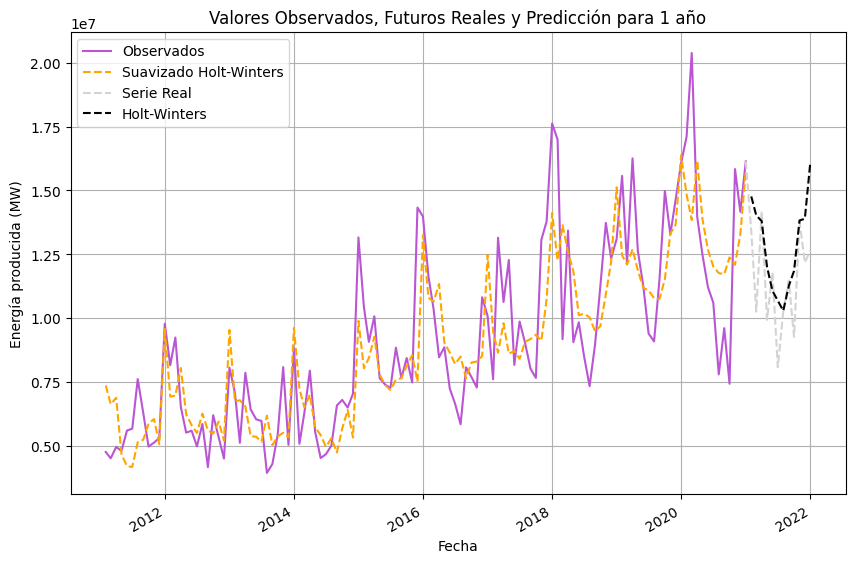

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(datos_TR.index, datos_TR['Power'], label='Observados', linestyle='-', color='mediumorchid')
plt.plot(datos_TR.index, modelo_holt_winters.fittedvalues, label='Suavizado Holt-Winters', linestyle='--', color='orange')
plt.plot(datos_rest.index, datos_rest['Power'], label='Serie Real', linestyle='--', color='lightgray')
plt.plot(predicciones_hw.index, predicciones_hw, label='Holt-Winters', linestyle='--',color='black')
plt.xlabel('Fecha')
plt.ylabel('Energía producida (MW)')
plt.title('Valores Observados, Futuros Reales y Predicción para 1 año')
plt.legend()
plt.xticks(rotation=30, ha='right')
plt.grid()
plt.show()

,Error,Error absoluto
Fecha,,
2021-01-31,1.363628e+06,10.173572
2021-02-28,3.773623e+06,36.804515
2021-03-31,3.919286e+05,2.762082
2021-04-30,2.083980e+06,20.988698
2021-05-31,7.315342e+05,6.201258
2021-06-30,2.609779e+06,32.324649
2021-07-31,1.699183e+04,0.165493
2021-08-31,2.186991e+05,1.906313
2021-09-30,2.588630e+06,27.950683


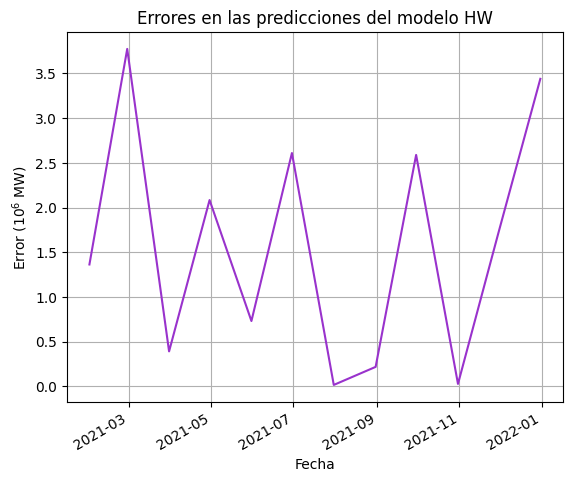

1.5804933468565519


In [21]:
errores = abs(datos_rest['Power']-predicciones_hw)
errores = errores.dropna()
errores_absolutos = 100*errores/datos_rest['Power']
errores_absolutos = errores_absolutos.dropna()
df_errores = pd.DataFrame({'Fecha': errores.index,
                            'Error': errores,
                            'Error absoluto': errores_absolutos})
df_errores.index = df_errores['Fecha']
df_errores = df_errores.drop('Fecha', axis = 1)
display(df_errores)
plt.plot(errores*1e-6, label='errores', linestyle='-', color='darkorchid')
plt.xticks(rotation=30, ha='right')
plt.grid()
plt.xlabel('Fecha')
plt.ylabel(r'Error ($10^6$ MW)')
plt.title('Errores en las predicciones del modelo HW')
plt.show()

print(np.mean(errores)*1e-6)

In [22]:
datos_log = np.log(datos_TR['Power'])
datos_log_diff = datos_log.diff().dropna()
modelo_hw_diff = sm.tsa.ExponentialSmoothing(datos_log_diff, trend='add', seasonal='add', seasonal_periods=12).fit()
pred_diff = modelo_hw_diff.forecast(steps=12)
last_log_value = datos_log.iloc[-1]  
pred_log = last_log_value + pred_diff.cumsum()
predicciones_log = np.exp(pred_log)
modelo_hw_diff.summary()

Dep. Variable:,Power,No. Observations:,119
Model:,ExponentialSmoothing,SSE,6.599
Optimized:,True,AIC,-312.171
Trend:,Additive,BIC,-267.705
Seasonal:,Additive,AICC,-305.331
Seasonal Periods:,12,Date:,"Tue, 11 Mar 2025"
Box-Cox:,False,Time:,19:49:36
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,1.4902e-08,alpha,True
smoothing_trend,1.4901e-08,beta,True


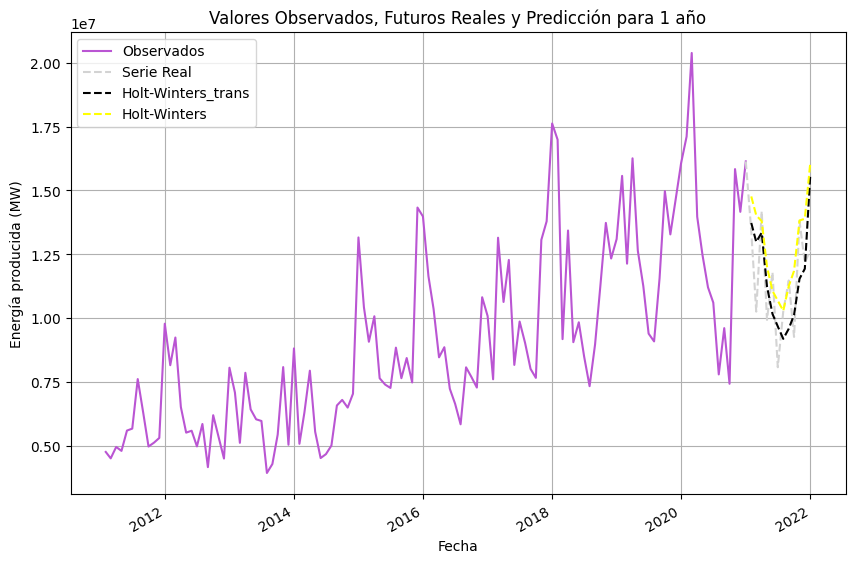

In [23]:
plt.figure(figsize=(10, 6))
plt.plot(datos_TR.index, datos_TR['Power'], label='Observados', linestyle='-', color='mediumorchid')
plt.plot(datos_rest.index, datos_rest['Power'], label='Serie Real', linestyle='--', color='lightgray')
plt.plot(predicciones_log.index, predicciones_log, label='Holt-Winters_trans', linestyle='--',color='black')
plt.plot(predicciones_hw.index, predicciones_hw, label='Holt-Winters', linestyle='--',color='yellow')
plt.xlabel('Fecha')
plt.ylabel('Energía producida (MW)')
plt.title('Valores Observados, Futuros Reales y Predicción para 1 año')
plt.legend()
plt.xticks(rotation=30, ha='right')
plt.grid()
plt.show()

,Error,Error absoluto
Fecha,,
2021-01-31,3.228410e+05,2.408610
2021-02-28,2.731441e+06,26.640004
2021-03-31,8.415676e+05,5.930872
2021-04-30,1.306785e+06,13.161217
2021-05-31,1.633066e+06,13.843598
2021-06-30,1.600191e+06,19.819920
2021-07-31,1.081817e+06,10.536417
2021-08-31,1.890540e+06,16.479086
2021-09-30,8.630322e+05,9.318572


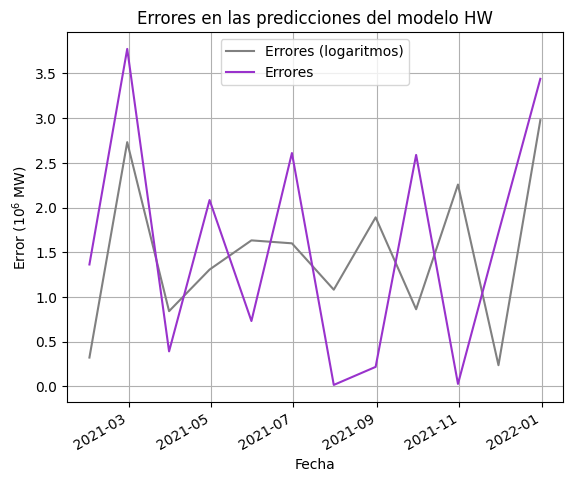

1.4785936870059566


In [24]:
errores_log = abs(datos_rest['Power']-predicciones_log)
errores_log = errores_log.dropna()
errores_absolutos_log = 100*errores_log/datos_rest['Power']
errores_absolutos_log = errores_absolutos_log.dropna()
df_errores_log = pd.DataFrame({'Fecha': errores_log.index,
                            'Error': errores_log,
                            'Error absoluto': errores_absolutos_log})
df_errores_log.index = df_errores_log['Fecha']
df_errores_log = df_errores_log.drop('Fecha', axis = 1)
display(df_errores_log)
plt.plot(errores_log*1e-6, label='Errores (logaritmos)', linestyle='-', color='gray')
plt.plot(errores*1e-6, label='Errores', linestyle='-', color='darkorchid')
plt.legend()
plt.xticks(rotation=30, ha='right')
plt.grid()
plt.xlabel('Fecha')
plt.ylabel(r'Error ($10^6$ MW)')
plt.title('Errores en las predicciones del modelo HW')
plt.show()

print(np.mean(errores_log)*1e-6)

### 4.2. Funciones de autocorrelación (ACF) y autocorrelación parcial (PACF).

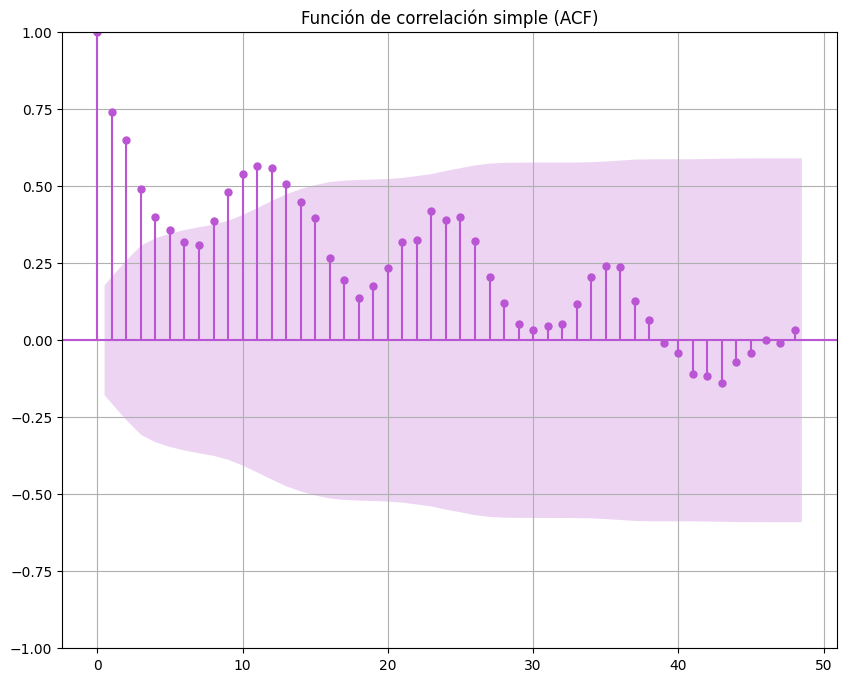

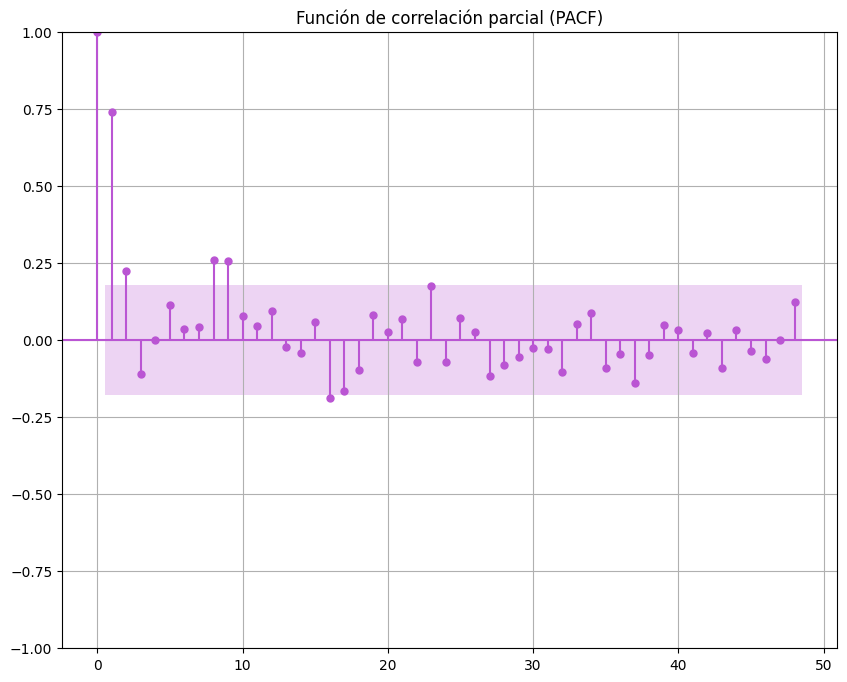

In [25]:
fig, ax = plt.subplots(figsize=(10, 8))
plot_acf(datos_TR['Power'],lags=48, alpha=0.05, ax = ax, color = 'mediumorchid', vlines_kwargs={"colors": 'mediumorchid'})
for item in ax.collections:
    if type(item)==PolyCollection:
        item.set_facecolor('mediumorchid')
plt.title('Función de correlación simple (ACF)')
plt.grid()
plt.show()

fig, ax = plt.subplots(figsize=(10, 8))
plot_pacf(datos_TR['Power'], lags=48, alpha=0.05, ax = ax, color = 'mediumorchid', vlines_kwargs={"colors": 'mediumorchid'})
for item in ax.collections:
    if type(item)==PolyCollection:
        item.set_facecolor('mediumorchid')
plt.title('Función de correlación parcial (PACF)')
plt.grid()
plt.show()

### 4.3. Modelo autorregresivo. Parámetros no estacionales.

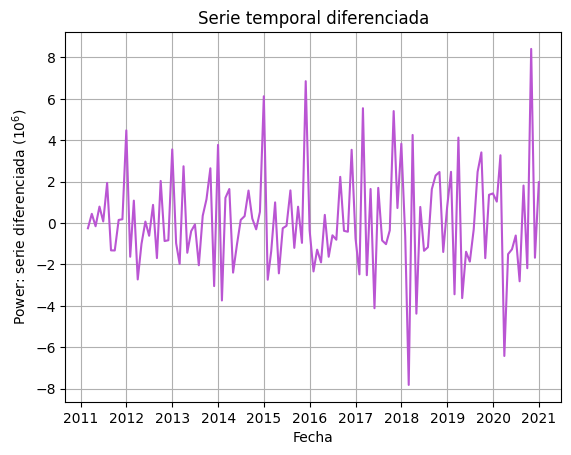

Test estacionariedad serie original
ADF Statistic: -0.35011218119242615, p-value: 0.9181009768512378
KPSS Statistic: 1.6791815858471366, p-value: 0.01

Test estacionariedad serie diferenciada de orden 1
ADF Statistic: -6.741062043704172, p-value: 3.1180146180110975e-09
KPSS Statistic: 0.01801705850158802, p-value: 0.1


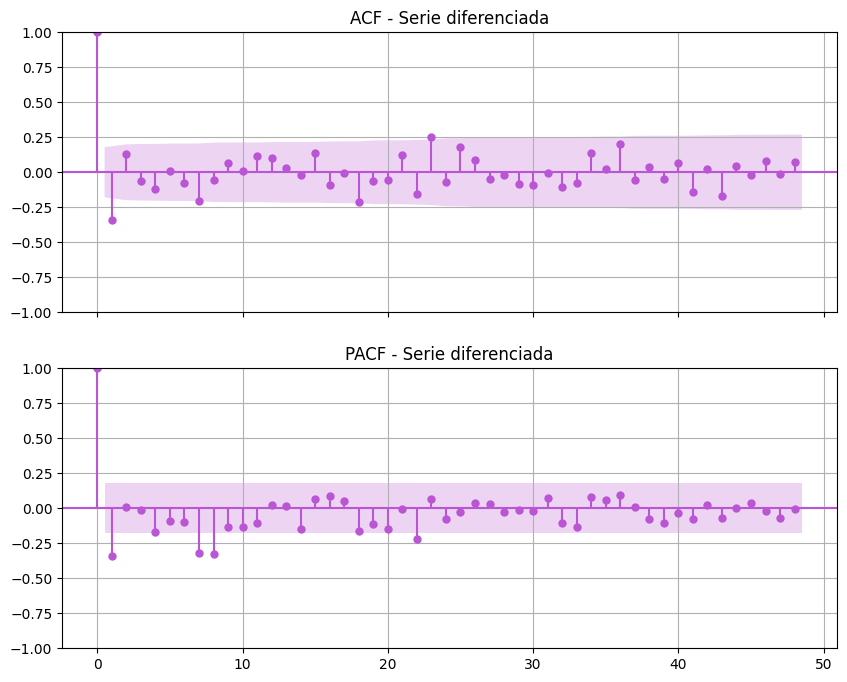

In [26]:
# SERIE DIFERENCIADA A ORDEN 1.
power = datos_TR['Power']
datos_diff_1 = power.diff().dropna()
sns.lineplot(datos_diff_1*1e-6, color = 'mediumorchid')
plt.title('Serie temporal diferenciada')
plt.grid()
plt.xlabel('Fecha')
plt.xticks()
plt.ylabel(r'Power: serie diferenciada ($10^6$)')
plt.show()

print('Test estacionariedad serie original')
print(f'ADF Statistic: {adfuller(datos_TR['Power'])[0]}, p-value: {adfuller(datos_TR['Power'])[1]}')
print(f'KPSS Statistic: {kpss(datos_TR['Power'])[0]}, p-value: {kpss(datos_TR['Power'])[1]}')

print('\nTest estacionariedad serie diferenciada de orden 1')
print(f'ADF Statistic: {adfuller(datos_diff_1)[0]}, p-value: {adfuller(datos_diff_1)[1]}')
print(f'KPSS Statistic: {kpss(datos_diff_1)[0]}, p-value: {kpss(datos_diff_1)[1]}')

fig, axs=plt.subplots(nrows=2,ncols=1,figsize=(10,8),sharex=True)
plt.grid()

plot_acf(datos_diff_1, ax=axs[0], lags=48, alpha=0.05, color = 'mediumorchid', vlines_kwargs={"colors": 'mediumorchid'})
axs[0].set_title('ACF - Serie diferenciada')
for item in axs[0].collections:
    if type(item)==PolyCollection:
        item.set_facecolor('mediumorchid')

plot_pacf(datos_diff_1, ax=axs[1], lags=48, alpha=0.05, color = 'mediumorchid', vlines_kwargs={"colors": 'mediumorchid'})
axs[1].set_title('PACF - Serie diferenciada')
for item in axs[1].collections:
    if type(item)==PolyCollection:
        item.set_facecolor('mediumorchid')

axs[0].grid()

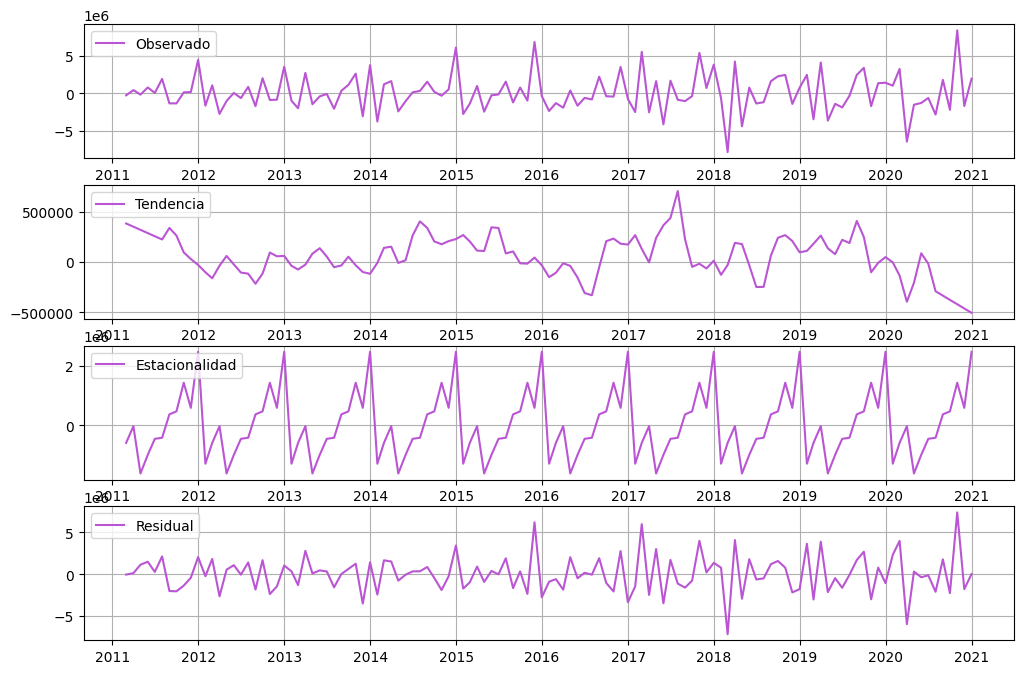

In [27]:
# Descomposición de la serie original y la serie diferenciada
# ==============================================================================
res_decompose = seasonal_decompose(datos_diff_1, model='additive', extrapolate_trend='freq')
plt.figure(figsize=(12, 8))
plt.subplot(4, 1, 1)
plt.plot(res_decompose.observed, label='Observado', color = 'mediumorchid')
plt.legend(loc='upper left')
plt.grid()
plt.subplot(4, 1, 2)
plt.plot(res_decompose.trend, label='Tendencia', color = 'mediumorchid')
plt.legend(loc='upper left')
plt.grid()
plt.subplot(4, 1, 3)
plt.plot(res_decompose.seasonal, label='Estacionalidad', color = 'mediumorchid')
plt.legend(loc='upper left')
plt.grid()
plt.subplot(4, 1, 4)
plt.plot(res_decompose.resid, label='Residual', color = 'mediumorchid')
plt.legend(loc='upper left')
plt.grid()
plt.show()

### 4.4. Modelo autorregresivo. Parámetros estacionales.

In [36]:
# Diferenciaciación de orden 1 combinada con diferenciación estacional
# ==============================================================================
datos_diff_1_12 = datos_diff_1.diff(12).dropna()
print('Test estacionariedad para la serie diferenciada a orden 12')
print(f'ADF Statistic: {adfuller(datos_diff_1_12)[0]}, p-value: {adfuller(datos_diff_1_12)[1]}')
print(f'KPSS Statistic: {kpss(datos_diff_1_12)[0]}, p-value: {kpss(datos_diff_1_12)[1]}')

Test estacionariedad para la serie diferenciada a orden 12
ADF Statistic: -3.9011964932002763, p-value: 0.0020260591994049047
KPSS Statistic: 0.04652778793900348, p-value: 0.1


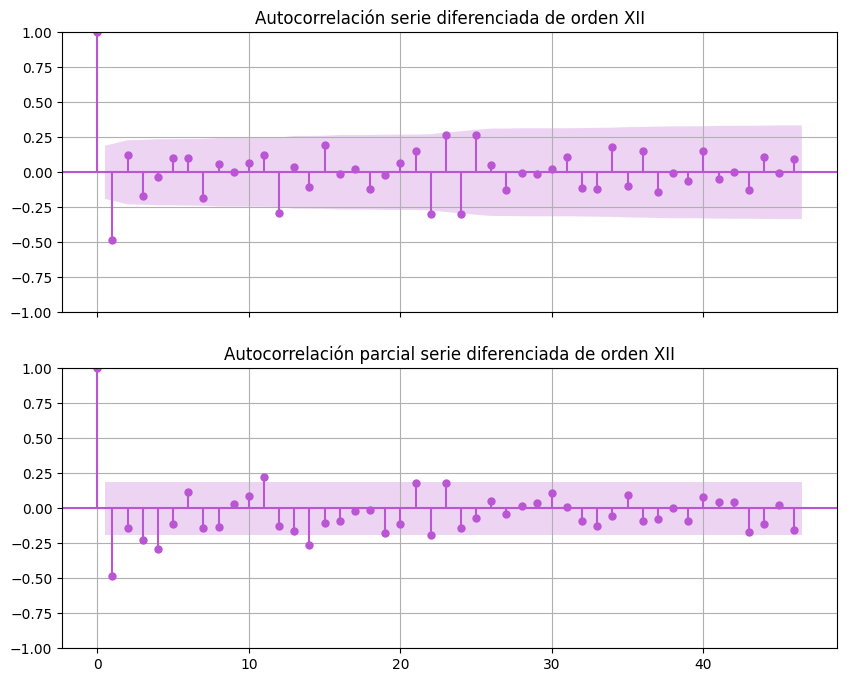

In [44]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 8), sharex=True)
plt.grid()

plot_acf(datos_diff_1_12, ax=axs[0], lags=46, alpha=0.05, color = 'mediumorchid', vlines_kwargs={"colors": 'mediumorchid'})
axs[0].set_title('Autocorrelación serie diferenciada de orden XII')
for item in axs[0].collections:
    if type(item)==PolyCollection:
        item.set_facecolor('mediumorchid')

plot_pacf(datos_diff_1_12, ax=axs[1], lags=46, alpha=0.05, color = 'mediumorchid', vlines_kwargs={"colors": 'mediumorchid'})
axs[1].set_title('Autocorrelación parcial serie diferenciada de orden XII')
for item in axs[1].collections:
    if type(item)==PolyCollection:
        item.set_facecolor('mediumorchid')
axs[0].grid()

In [30]:
# Modelo SARIMAX con statsmodels.Sarimax
# ==============================================================================
warnings.filterwarnings("ignore", category=UserWarning, message='Non-invertible|Non-stationary')
modelo = SARIMAX(endog = datos, order = (1, 1, 2), seasonal_order = (1, 1, 0, 12))
modelo_res = modelo.fit(disp=0)
warnings.filterwarnings("default")
modelo_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               Power   No. Observations:                  132
Model:             SARIMAX(1, 1, 2)x(1, 1, [], 12)   Log Likelihood               -1922.700
Date:                             Tue, 11 Mar 2025   AIC                           3855.400
Time:                                     19:49:37   BIC                           3869.295
Sample:                                 01-31-2011   HQIC                          3861.042
                                      - 12-31-2021                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5054      1.611     -0.314      0.754      -3.663       2.652
ma.L1         -0.2693      1.648     -0.163      0.870      -3.499       2.960
ma.L2         -0.3073      1.292     -0.238      0.812      -2.840       2.225
ar.S.L12      -0.5579      0.106     -5.270      0.000      -0.765      -0.350
sigma2       8.52e+12   1.23e-12   6.95e+24      0.000    8.52e+12    8.52e+12
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                11.90
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               2.03   Skew:                             0.50
Prob(H) (two-sided):                  0.03   Kurtosis:                         4.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.01e+40. Standard errors may be unstable.
"""

In [31]:
from statsmodels.stats.diagnostic import acorr_ljungbox
estadistico_lb, p_valor_lb = acorr_ljungbox(modelo_res.resid, lags=[12])

2022-01-31    1.372285e+07
2022-02-28    1.403899e+07
2022-03-31    1.225771e+07
2022-04-30    9.506988e+06
Freq: ME, Name: predicciones_statsmodels, dtype: float64

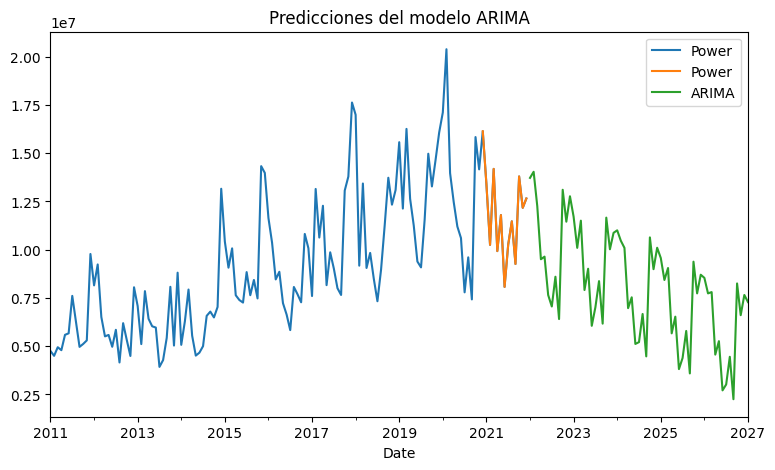

In [32]:
# Predicción
# ==============================================================================
predicciones_statsmodels = modelo_res.get_forecast(steps=61).predicted_mean
predicciones_statsmodels.name = 'predicciones_statsmodels'
display(predicciones_statsmodels.head(4))

# Plot predictions
fig, ax = plt.subplots(figsize=(9, 5))
datos.plot(ax=ax, label='Serie')
datos_rest.plot(ax=ax, label='Reales')
predicciones_statsmodels.plot(ax=ax, label='ARIMA')
ax.set_title('Predicciones del modelo ARIMA')
ax.legend();

In [33]:
# Mean Squared Error (MSE)
mse = mean_squared_error(datos_rest, predicciones_statsmodels[:len(datos_rest)])
print(f'Mean Squared Error (MSE): {mse}')

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Mean Absolute Error (MAE)
mae = mean_absolute_error(datos_rest, predicciones_statsmodels[:len(datos_rest)])
print(f'Mean Absolute Error (MAE): {mae}')

Mean Squared Error (MSE): 7723895622041.203
Root Mean Squared Error (RMSE): 2779189.7420005715
Mean Absolute Error (MAE): 2280113.350825486
